In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16,ResNet50


## Carga de los directorios de las imágenes

In [2]:
images = []

In [3]:
# Directorio donde están almacenadas las imágenes
image_dir = 'C:/Users/andre/Documents/Video07/framesVideo/surco-rouviere'
image_dir2 = 'C:/Users/andre/Documents/Video02/framesVideo/extraccion'

## Procesamiento de la imágenes

Se redimensionan a un tamaño de 224x224 y se normalizan, adicionalmente se obtienen los labels de cada imagen que coresponden a :

0 - antes de la cirugía

1 - durante la cirugía 

2 - después de cirugía

In [ ]:
def read_imageResize_with_labels(dir='..\database\dataset', target_size=(224, 224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la carpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio que contiene las carpetas 'antes-cirugia', 
               'durante-cirugia', y 'despues-cirugia'. Las carpetas deben estar en la 
               misma ubicación. Las carpetas no definidas recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    
    # Definir las carpetas y sus etiquetas correspondientes
    class_folders = {
        'antes-cirugia-grande': 0,
        'durante-cirugia': 1,
        'despues-cirugia-grande': 2
    }

    # Procesar cada carpeta en el directorio principal
    for folder, label in class_folders.items():
        folder_path = os.path.join(dir, folder)
        
        if not os.path.isdir(folder_path):
            print(f"Advertencia: {folder_path} no es un directorio válido.")
            continue
        
        # Procesar cada imagen en la carpeta
        for name_image in os.listdir(folder_path):
            # Obtener la ruta de la imagen
            image_path = os.path.join(folder_path, name_image)
            
            # Leer la imagen 
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Redimensionar la imagen
            image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
            image = image / 255.0

            # Agregar la imagen y su etiqueta a las listas
            imgs.append(image)
            labels.append(label)
    
    return np.array(imgs), labels

In [5]:
# Llamar a la función con la ruta adecuada
images, labels = read_imageResize_with_labels(dir='./')

# Verificar el tamaño de los arrays resultantes
print(f"Número de imágenes: {images.shape[0]}")
print(f"Tamaño de cada imagen: {images.shape[1:]}")

# Verificar las etiquetas
print(f"Etiquetas únicas: {set(labels)}")

Número de imágenes: 3007
Tamaño de cada imagen: (224, 224, 3)
Etiquetas únicas: {0, 1, 2}


In [6]:
print(type(images[0]))

<class 'numpy.ndarray'>


In [7]:
print(images.shape)

(3007, 224, 224, 3)


In [8]:
labels[0:3]

[0, 0, 0]

In [9]:
def visualize_images_by_class(X, y, class_labels, num_images=5):
    """
    Visualiza un número específico de imágenes de cada clase.

    Parámetros:
    -----------
    X : np.ndarray
        Conjunto de imágenes.
    y : np.ndarray
        Etiquetas de las imágenes (deben ser en formato de índices de clase, no one-hot encoding).
    class_labels : list
        Lista de nombres de las clases (en orden).
    num_images : int, opcional
        Número de imágenes a visualizar por clase. Por defecto es 5.
    """
    num_classes = len(class_labels)
    plt.figure(figsize=(15, num_classes * 3))
    
    for i, class_label in enumerate(class_labels):
        # Filtrar las imágenes de la clase actual
        class_indices = [idx for idx, label in enumerate(y) if label == i]
        
        # Seleccionar aleatoriamente `num_images` imágenes de esta clase
        selected_indices = np.random.choice(class_indices, num_images, replace=False)
        
        for j, idx in enumerate(selected_indices):
            plt.subplot(num_classes, num_images, i * num_images + j + 1)
            plt.imshow(X[idx])
            plt.title(f'Class {i}: {class_label}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()




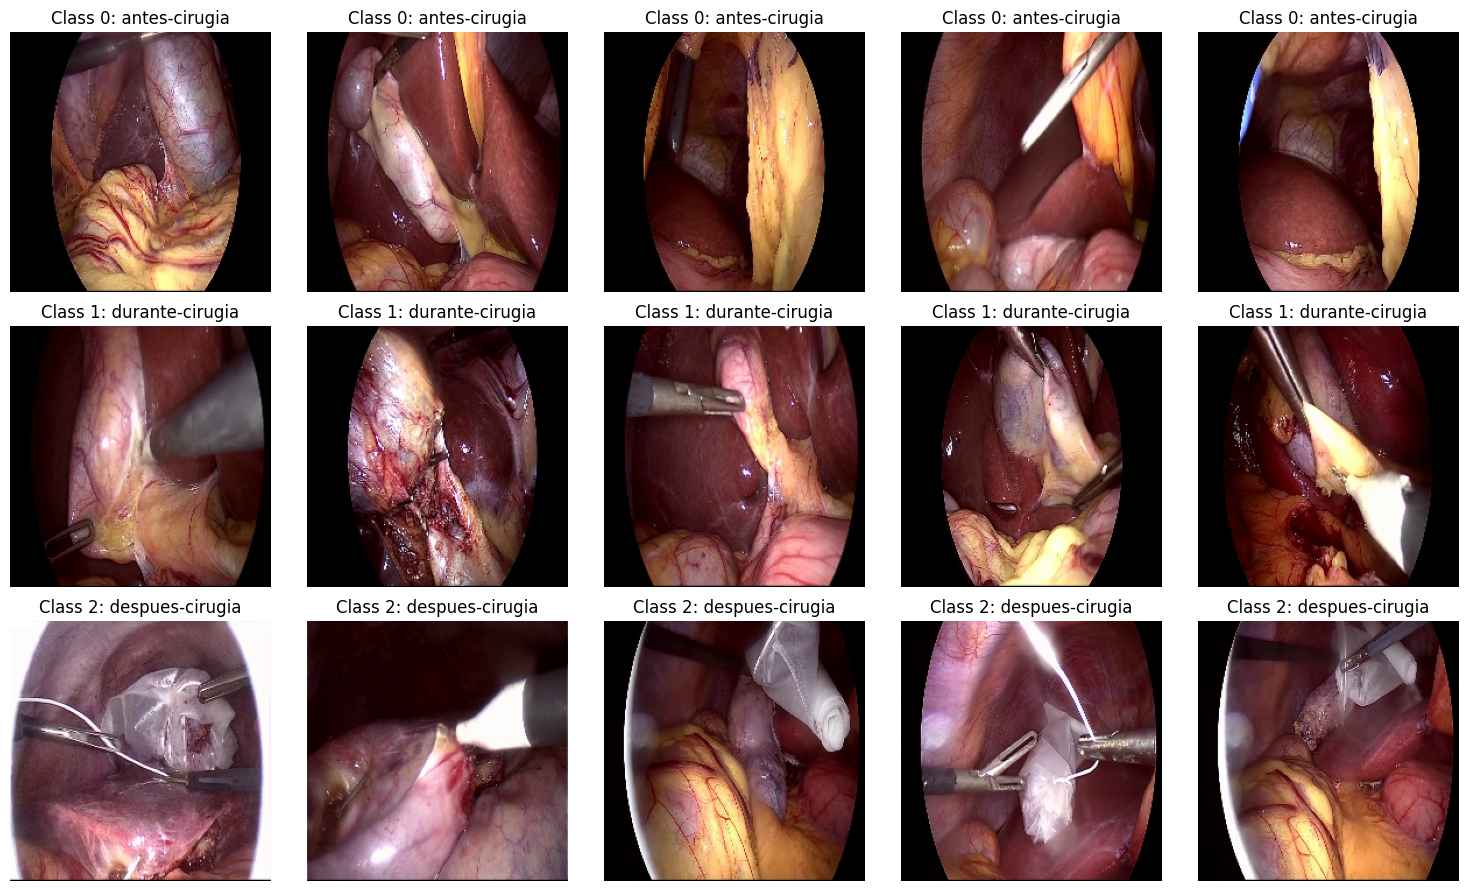

In [10]:
visualize_images_by_class(images, labels, class_labels=['antes-cirugia', 'durante-cirugia', 'despues-cirugia'])

In [11]:
images.shape

(3007, 224, 224, 3)

## División train-test 
Se obtienen los conjuntos de entrenamiento y validación, con un porcentaje correspondiente a 80% entrenamiento 20% validación

In [12]:
labels = np.array(labels)

In [13]:


# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val= train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Convertir las etiquetas a formato one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)



In [14]:
from collections import Counter 
# Verificar las proporciones en los conjuntos de entrenamiento, validación y prueba
print("Proporciones en el conjunto de entrenamiento:", Counter(y_train))
print("Proporciones en el conjunto de validación:", Counter(y_val))


Proporciones en el conjunto de entrenamiento: Counter({0: 803, 1: 802, 2: 800})
Proporciones en el conjunto de validación: Counter({1: 201, 0: 201, 2: 200})


## Entrenamiento de modelo de transfer learning

Se crea un callback para detener el modelo sí se alcanza el val_accuracy deseado, se agrega un early stopping para detener el entrenamiento en caso de que se estanque el accuracy a las 15 épocas.

Se cren modelos con transfer learning usando la arquitectura de VGG16 y Resnet50, también se permite el entrenamiendo de capas de las arquitecturas , aparte de las capas densas agregadas

In [15]:
#Early stopping para que se detenga el entranamiento si a las 15 épocas no mejora el accuracy

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

In [16]:
# callback para detener el entrenamiento si se alcanza el accuracy deseado
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.96):
      print("Accuracy alcanzado")
      self.model.stop_training = True

In [17]:
stop = myCallback()

In [18]:
def create_model(base_model_name='VGG16', input_shape=(224, 224, 3), freeze_base_model=True,layers_to_train=0):
    """
    Crea un modelo basado en VGG16 o ResNet50 con la estructura especificada para predecir clases
    utilizando imágenes y coordenadas como entradas.

    Parámetros:
    -----------
    base_model_name : str, opcional
        Nombre del modelo base a utilizar ('VGG16' o 'ResNet50'). Por defecto es 'VGG16'.
    input_shape : tuple, opcional
        Tamaño de la entrada de las imágenes. Por defecto es (224, 224, 3).
    coord_shape : tuple, opcional
        Tamaño de la entrada para las coordenadas. Por defecto es (3, 4).
    freeze_base_model : bool, opcional
        Si True, congela las capas del modelo base. Por defecto es True.

    Retorno:
    --------
    model : keras.Model
        Modelo compilado listo para ser entrenado.
    """
    # Selección del modelo base
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("base_model_name must be either 'VGG16' or 'ResNet50'")

    # Congelar o descongelar capas del modelo base
    if freeze_base_model:
        for layer in base_model.layers:
            layer.trainable = False

        # Si se especifican capas a entrenar, descongelar las últimas `layers_to_train` capas
        if layers_to_train > 0:
            for layer in base_model.layers[-layers_to_train:]:
                layer.trainable = True
    else:
        # Si no se quiere congelar el modelo base, todas las capas serán entrenables
        for layer in base_model.layers:
            layer.trainable = True

    # Entrada para las imágenes
    image_input = base_model.input

    # Extraer características de la imagen
    x = base_model.output
    x = Flatten()(x)


    # Añadir capas densas finales
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)

    # Crear el modelo con  entrada de imágenes
    model = Model(inputs=image_input, outputs=output)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Resumen del modelo
    model.summary()

    return model


## VGG16
Arquitectura y entrenamiento

In [19]:
model_vgg16 = create_model(base_model_name='VGG16', input_shape=(224, 224, 3), freeze_base_model=True,layers_to_train=0)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# Paso 4: Entrenar el modelo
history_vgg16 = model_vgg16.fit(
    X_train, y_train_cat,
    epochs=10,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping])

Epoch 1/10
76/76 [==============================] - 35s 287ms/step - loss: 0.4584 - accuracy: 0.8254 - val_loss: 0.1523 - val_accuracy: 0.9601
Epoch 2/10
76/76 [==============================] - 15s 193ms/step - loss: 0.1271 - accuracy: 0.9667 - val_loss: 0.0744 - val_accuracy: 0.9801
Epoch 3/10
76/76 [==============================] - 15s 194ms/step - loss: 0.0750 - accuracy: 0.9800 - val_loss: 0.0544 - val_accuracy: 0.9850
Epoch 4/10
76/76 [==============================] - 15s 194ms/step - loss: 0.0533 - accuracy: 0.9871 - val_loss: 0.0369 - val_accuracy: 0.9934
Epoch 5/10
76/76 [==============================] - 15s 196ms/step - loss: 0.0393 - accuracy: 0.9917 - val_loss: 0.0399 - val_accuracy: 0.9884
Epoch 6/10
76/76 [==============================] - 15s 193ms/step - loss: 0.0284 - accuracy: 0.9946 - val_loss: 0.0363 - val_accuracy: 0.9917
Epoch 7/10
76/76 [==============================] - 15s 193ms/step - loss: 0.0237 - accuracy: 0.9975 - val_loss: 0.0204 - val_accuracy: 0.9967

## VGG16- última capa entrenada
Arquitectura y entrenamiento

In [21]:
model_vgg16_trainable= create_model(base_model_name='VGG16', input_shape=(224, 224, 3), freeze_base_model=True,layers_to_train=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
# Paso 4: Entrenar el modelo
history_vgg16_trainable = model_vgg16_trainable.fit(
    X_train, y_train_cat,
    epochs=10,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping])

Epoch 1/10
76/76 [==============================] - 17s 204ms/step - loss: 0.4057 - accuracy: 0.8437 - val_loss: 0.1352 - val_accuracy: 0.9635
Epoch 2/10
76/76 [==============================] - 15s 193ms/step - loss: 0.1185 - accuracy: 0.9692 - val_loss: 0.0690 - val_accuracy: 0.9767
Epoch 3/10
76/76 [==============================] - 15s 199ms/step - loss: 0.0688 - accuracy: 0.9834 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 4/10
76/76 [==============================] - 15s 200ms/step - loss: 0.0494 - accuracy: 0.9904 - val_loss: 0.0353 - val_accuracy: 0.9917
Epoch 5/10
76/76 [==============================] - 15s 196ms/step - loss: 0.0356 - accuracy: 0.9950 - val_loss: 0.0303 - val_accuracy: 0.9917
Epoch 6/10
76/76 [==============================] - 15s 198ms/step - loss: 0.0284 - accuracy: 0.9958 - val_loss: 0.0272 - val_accuracy: 0.9917
Epoch 7/10
76/76 [==============================] - 16s 204ms/step - loss: 0.0271 - accuracy: 0.9946 - val_loss: 0.0255 - val_accuracy: 0.9917

## Resnet50
Arquitectura y entrenamiento

In [23]:
model_resnet = create_model(base_model_name='ResNet50', input_shape=(224, 224, 3), freeze_base_model=True,layers_to_train=0)

# Paso 4: Entrenar el modelo

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [24]:


history_resnet = model_resnet.fit(
    X_train, y_train_cat,
    epochs=40,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping,stop])

Epoch 1/40
76/76 [==============================] - 14s 135ms/step - loss: 1.0991 - accuracy: 0.5035 - val_loss: 0.9158 - val_accuracy: 0.5349
Epoch 2/40
76/76 [==============================] - 9s 114ms/step - loss: 0.8651 - accuracy: 0.5958 - val_loss: 0.7816 - val_accuracy: 0.6595
Epoch 3/40
76/76 [==============================] - 8s 111ms/step - loss: 0.7978 - accuracy: 0.6299 - val_loss: 0.8093 - val_accuracy: 0.5997
Epoch 4/40
76/76 [==============================] - 9s 113ms/step - loss: 0.7252 - accuracy: 0.6769 - val_loss: 0.6382 - val_accuracy: 0.7176
Epoch 5/40
76/76 [==============================] - 9s 114ms/step - loss: 0.6621 - accuracy: 0.7252 - val_loss: 0.6493 - val_accuracy: 0.8206
Epoch 6/40
76/76 [==============================] - 8s 110ms/step - loss: 0.6320 - accuracy: 0.7430 - val_loss: 0.5381 - val_accuracy: 0.7907
Epoch 7/40
76/76 [==============================] - 8s 111ms/step - loss: 0.5958 - accuracy: 0.7518 - val_loss: 0.5746 - val_accuracy: 0.7890
Epoch

## Resnet50 - última capa entrenada
Arquitectura y entrenamiento

In [25]:
model_resnet_trainable = create_model(base_model_name='ResNet50', input_shape=(224, 224, 3), freeze_base_model=True,layers_to_train=1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [27]:


history_resnet_trainable = model_resnet_trainable.fit(
    X_train, y_train_cat,
    epochs=40,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping,stop])

Epoch 1/40
76/76 [==============================] - 15s 137ms/step - loss: 1.0442 - accuracy: 0.4965 - val_loss: 0.8589 - val_accuracy: 0.5997
Epoch 2/40
76/76 [==============================] - 7s 90ms/step - loss: 0.8577 - accuracy: 0.5879 - val_loss: 0.8412 - val_accuracy: 0.6146
Epoch 3/40
76/76 [==============================] - 6s 82ms/step - loss: 0.7999 - accuracy: 0.6424 - val_loss: 0.7125 - val_accuracy: 0.7276
Epoch 4/40
76/76 [==============================] - 6s 83ms/step - loss: 0.7446 - accuracy: 0.6661 - val_loss: 0.6909 - val_accuracy: 0.7292
Epoch 5/40
76/76 [==============================] - 6s 82ms/step - loss: 0.6793 - accuracy: 0.7210 - val_loss: 0.6057 - val_accuracy: 0.7591
Epoch 6/40
76/76 [==============================] - 6s 82ms/step - loss: 0.6321 - accuracy: 0.7322 - val_loss: 0.6168 - val_accuracy: 0.7774
Epoch 7/40
76/76 [==============================] - 6s 82ms/step - loss: 0.5960 - accuracy: 0.7563 - val_loss: 0.5549 - val_accuracy: 0.7890
Epoch 8/40


## Métricas

In [28]:
# Visualización de curvas de pérdida y precisión
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    
    plt.show()

In [29]:
def evaluate_model(model, X_val, y_val_cat, class_names=['antes-cirugia', 'durante-cirugia', 'despues-cirugia']):
    """
    Evalúa el modelo en el conjunto de validación y genera un reporte de clasificación
    junto con una matriz de confusión.

    Parámetros:
    -----------
    model : keras.Model
        Modelo entrenado que se va a evaluar.
    X_val : np.ndarray
        Conjunto de datos de validación (imágenes).
    coord_val : np.ndarray
        Conjunto de datos de validación (coordenadas).
    y_val_cat : np.ndarray
        Etiquetas de validación en formato one-hot.
    class_names : list
        Lista con los nombres de las clases (por defecto: ['antes-cirugia', 'durante-cirugia', 'despues-cirugia']).

    Retorno:
    --------
    None
    """
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Generar predicciones para el conjunto de validación
    y_val_pred = model.predict(X_val)

    # Convertir predicciones y etiquetas reales a sus índices de clase
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val_cat, axis=1)

    # Generar un reporte de clasificación
    report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names)
    print("Classification Report:\n", report)

    # Generar una matriz de confusión
    conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()



## Resultados

**VGG16**  

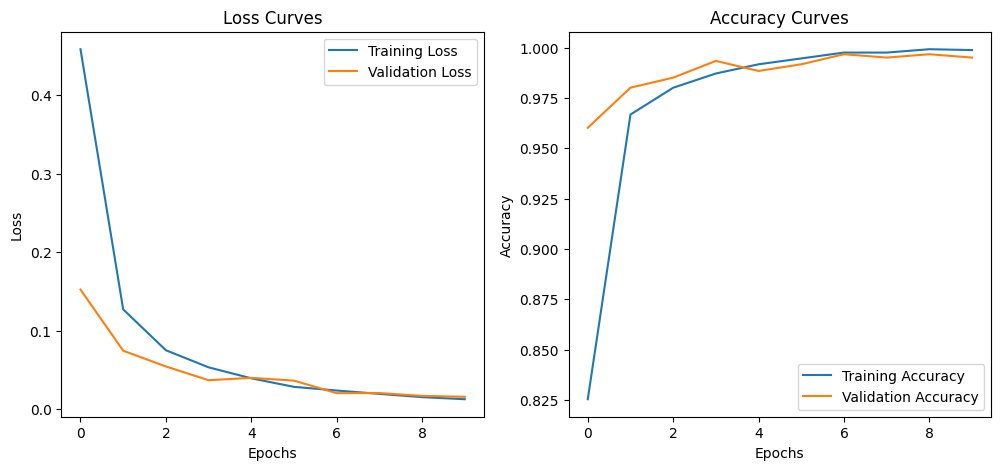

In [30]:
plot_training_history(history_vgg16)

In [31]:
# Evaluar el modelo en los datos de validación
val_loss, val_accuracy = model_vgg16.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


19/19 [==============================] - 2s 102ms/step - loss: 0.0158 - accuracy: 0.9950
Validation Loss: 0.01575438305735588
Validation Accuracy: 0.9950166344642639


19/19 [==============================] - 2s 103ms/step
Classification Report:
                  precision    recall  f1-score   support

  antes-cirugia       0.99      1.00      1.00       201
durante-cirugia       1.00      1.00      1.00       201
despues-cirugia       0.99      0.99      0.99       200

       accuracy                           1.00       602
      macro avg       1.00      1.00      1.00       602
   weighted avg       1.00      1.00      1.00       602



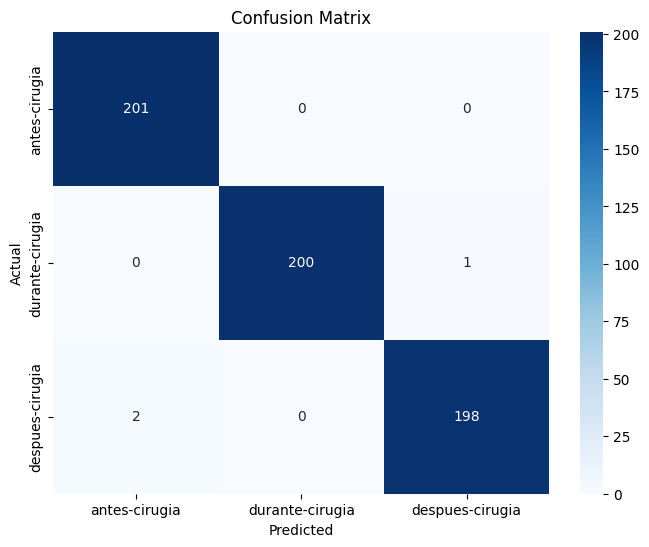

In [32]:
evaluate_model(model_vgg16, X_val, y_val_cat)


**VGG16 última capa entrenada**

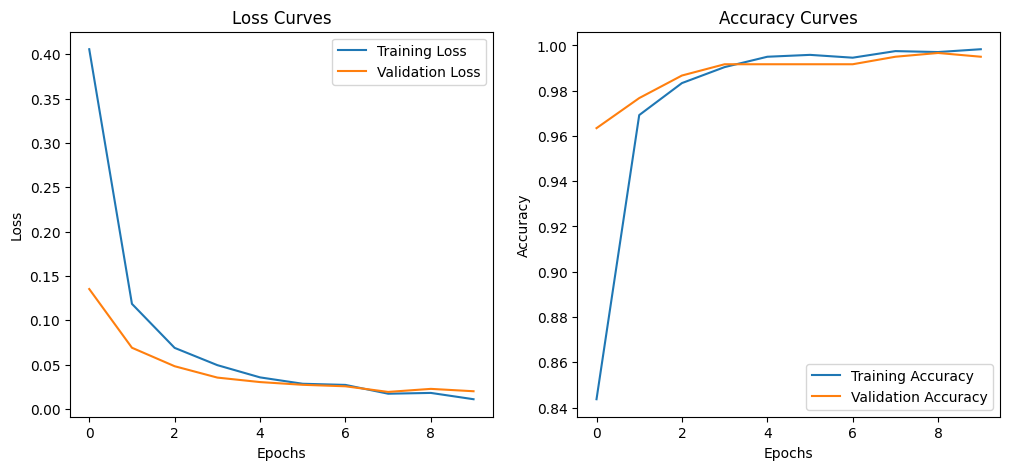

In [33]:
plot_training_history(history_vgg16_trainable)

In [34]:
# Evaluar el modelo en los datos de validación
val_loss, val_accuracy = model_vgg16_trainable.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


19/19 [==============================] - 2s 102ms/step - loss: 0.0199 - accuracy: 0.9950
Validation Loss: 0.019931402057409286
Validation Accuracy: 0.9950166344642639


19/19 [==============================] - 2s 100ms/step
Classification Report:
                  precision    recall  f1-score   support

  antes-cirugia       0.99      1.00      1.00       201
durante-cirugia       1.00      1.00      1.00       201
despues-cirugia       0.99      0.99      0.99       200

       accuracy                           1.00       602
      macro avg       1.00      1.00      1.00       602
   weighted avg       1.00      1.00      1.00       602



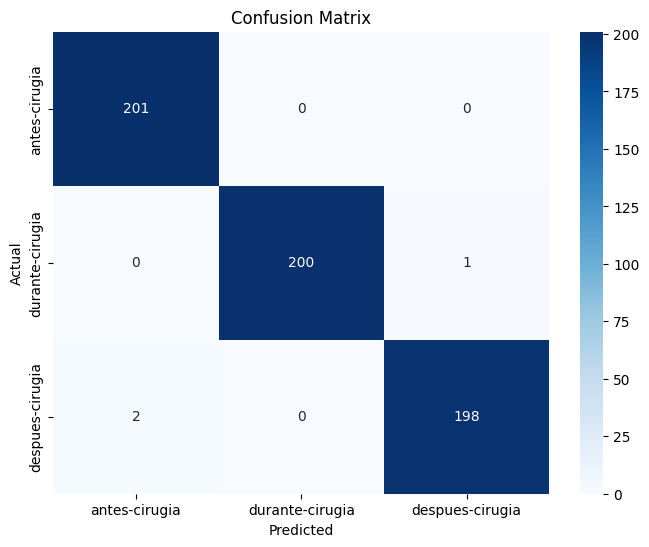

In [35]:
evaluate_model(model_vgg16_trainable, X_val, y_val_cat)


**Resnet50**

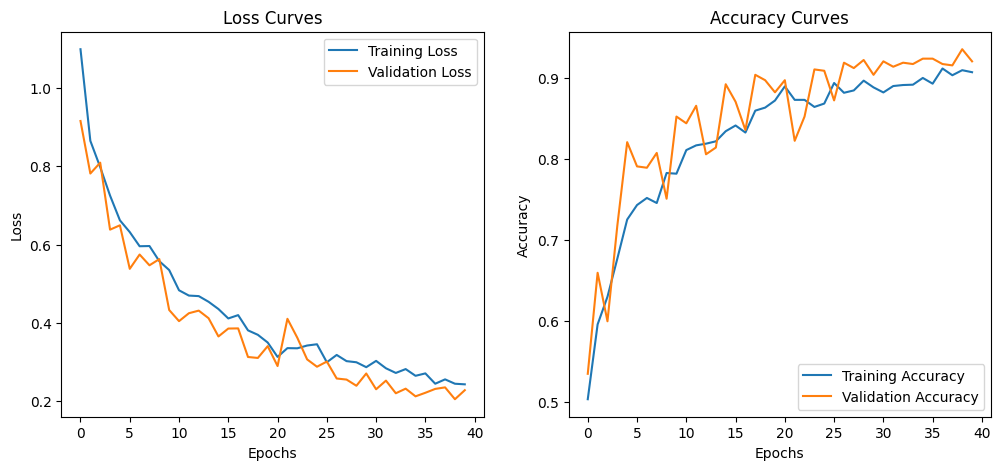

In [36]:
plot_training_history(history_resnet)

In [37]:
# Evaluar el modelo en los datos de validación
val_loss, val_accuracy = model_resnet.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

19/19 [==============================] - 1s 65ms/step - loss: 0.2280 - accuracy: 0.9203
Validation Loss: 0.22804434597492218
Validation Accuracy: 0.920265793800354


19/19 [==============================] - 2s 62ms/step
Classification Report:
                  precision    recall  f1-score   support

  antes-cirugia       0.87      0.99      0.92       201
durante-cirugia       0.97      0.90      0.93       201
despues-cirugia       0.94      0.88      0.91       200

       accuracy                           0.92       602
      macro avg       0.92      0.92      0.92       602
   weighted avg       0.92      0.92      0.92       602



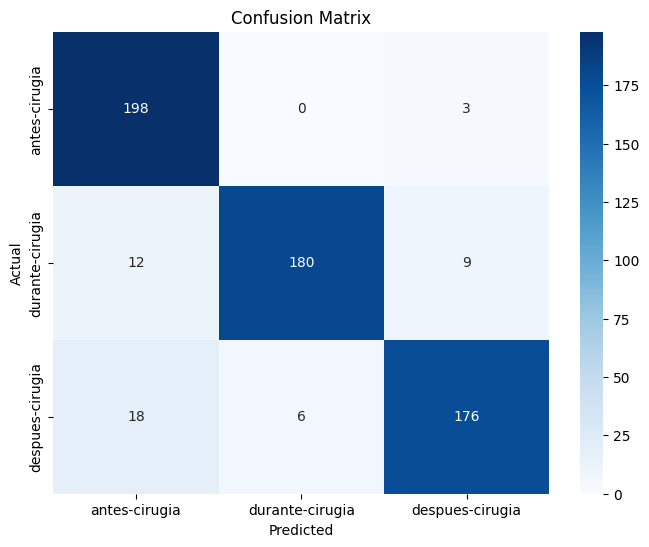

In [38]:
evaluate_model(model_resnet, X_val, y_val_cat)

**Resnet50 última capa entrenada**

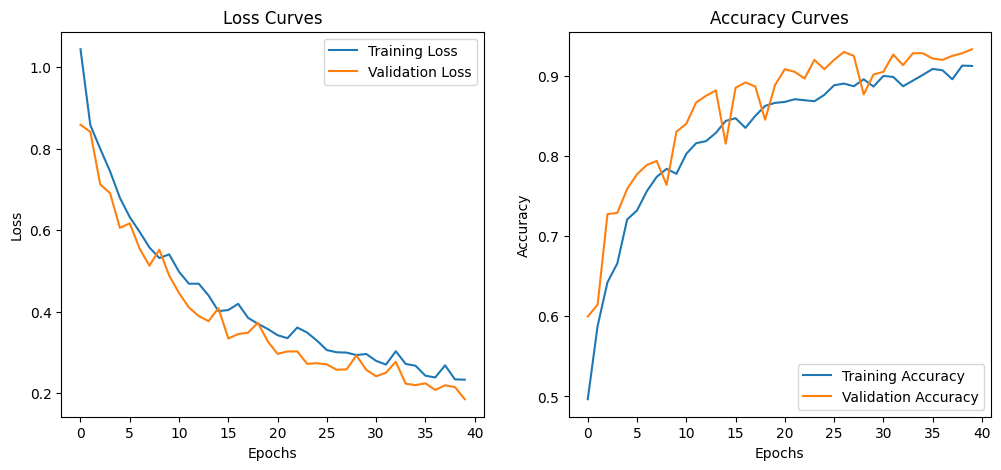

In [39]:
plot_training_history(history_resnet_trainable)

In [40]:
# Evaluar el modelo en los datos de validación
val_loss, val_accuracy = model_resnet_trainable.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

19/19 [==============================] - 1s 64ms/step - loss: 0.1850 - accuracy: 0.9336
Validation Loss: 0.18502362072467804
Validation Accuracy: 0.9335548281669617


19/19 [==============================] - 2s 64ms/step
Classification Report:
                  precision    recall  f1-score   support

  antes-cirugia       0.92      0.96      0.94       201
durante-cirugia       0.95      0.95      0.95       201
despues-cirugia       0.93      0.90      0.91       200

       accuracy                           0.93       602
      macro avg       0.93      0.93      0.93       602
   weighted avg       0.93      0.93      0.93       602



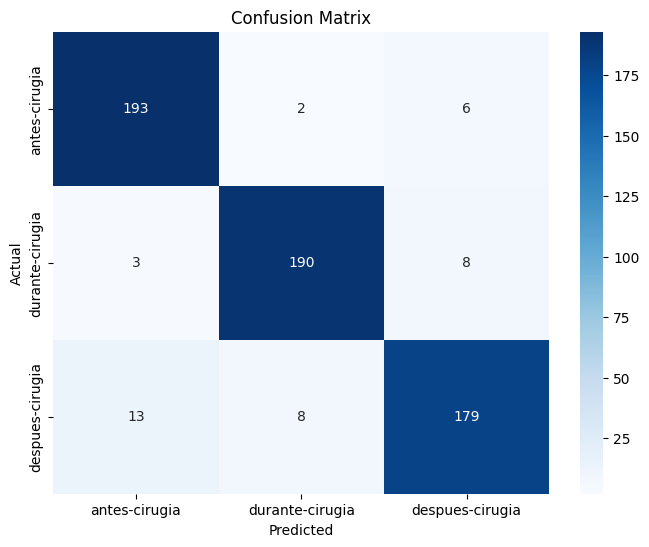

In [41]:
evaluate_model(model_resnet_trainable, X_val, y_val_cat)

**Comparación modelos**

In [42]:
def plot_comparison(history_vgg16, history_resnet50,history_vgg16_trainable,history_resnet_trainable):
    """
    Genera una gráfica comparativa de la pérdida (loss) y precisión (accuracy) entre dos modelos entrenados.

    Parámetros:
    -----------
    history_vgg16 : keras.callbacks.History
        Historial de entrenamiento del modelo VGG16.
    history_resnet50 : keras.callbacks.History
        Historial de entrenamiento del modelo ResNet50.
    """
    plt.figure(figsize=(14, 6))

    # Comparación de la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
    plt.plot(history_vgg16_trainable.history['val_accuracy'], label='VGG16 Trainable Validation Accuracy')
    plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation Accuracy')
    plt.plot(history_resnet_trainable.history['val_accuracy'], label='ResNet50 Trainable Validation Accuracy')
    plt.title('Comparación de validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Val accuracy')
    plt.legend()

    # Comparación de la precisión
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
    plt.plot(history_vgg16_trainable.history['accuracy'], label='VGG16 Trainable Training Accuracy')
    plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Training Accuracy')
    plt.plot(history_resnet_trainable.history['accuracy'], label='ResNet50 Trainable Training Accuracy')
    plt.title('Comparación de accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


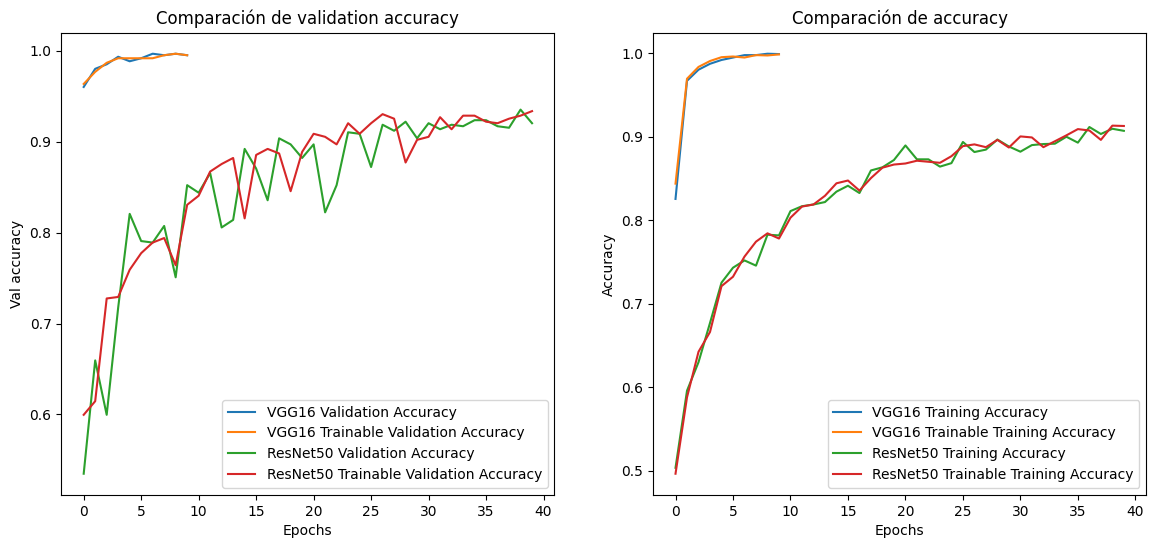

In [43]:
plot_comparison(history_vgg16, history_resnet,history_vgg16_trainable,history_resnet_trainable)


El modelo que se ha diseñado y entrenado está configurado para predecir las clases generales de las imágenes, es decir, está diseñado para determinar si una imagen pertenece a la clase "antes de la cirugía", "durante la cirugía" o "después de la cirugía".

**¿Por qué el modelo predice las clases de las imágenes?**

**Salida del Modelo:**

La última capa del modelo es una capa Dense con 3 neuronas y una activación softmax. Esta configuración indica que el modelo está diseñado para clasificar las entradas en una de tres clases posibles: 0, 1, o 2.

0: Antes de la cirugía.
1: Durante la cirugía.
2: Después de la cirugía.


**Entrada del Modelo:**

El modelo tiene una entrada:

Imágenes: Representadas por X_train, que son las imágenes en sí mismas.



**Dado que la salida es una clasificación en una de las tres clases generales, el objetivo del modelo es determinar el contexto general de la imagen completa, no la clasificación de las regiones individuales.**